# Faking Data For Training


In [12]:
# Imports should be collected at the top, as a standard programming convention

# This turns off a warning about a deprecation in Pandas, from coude referenced by Statsmodel. 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# These imports are the most common for data analysis, 
# and they are given standard aliases. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For other imports, we only need one or two 
# functions, rather than the whole module. 
from scipy.stats import zscore
from pathlib import Path
from os import environ

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.formula.api import ols

# Faking Great Results




In [13]:
# First we will load the datasets, combine them, and do some cleanup. 

# The directory in Google Drive where our files are stored. 

if Path('/gdrive').is_dir():
    data_dir = Path('/gdrive/Shared drives/Wood/Data/')
    
elif environ.get('WOODPLC_DATA_DIR'):
    # To run locally, download the Woodplc data directory, or setup Google Drive Stream to mount it, 
    # then set the environmental variable to the directory   
    data_dir = Path(environ.get('WOODPLC_DATA_DIR'))
    
pola_data_dir = data_dir.joinpath('POLA Water Quality Database Files/CTD Files Organized for Python/Ready for Access')

pola = pd.read_csv(data_dir.joinpath('pola_tidy.csv')).set_index(['sitename','datetime'])
pola.head()

depth  dissolved_oxygen  fluorescence     ph  \
sitename datetime                                                            
AS1      2018-07-17 11:49:00    0.5           7.16056        2.9065  8.094   
         2018-07-17 11:49:00    1.0           7.17666        3.0533  8.090   
         2018-07-17 11:49:00    1.5           7.13837        3.4530  8.091   
         2018-07-17 11:49:00    2.0           7.10275        4.0010  8.088   
         2018-07-17 11:49:00    2.5           7.06786        4.6305  8.090   

                              salinity  temperature  transmissivity  turbidity  
sitename datetime                                                               
AS1      2018-07-17 11:49:00   33.6155      19.9630         75.6053   0.671335  
         2018-07-17 11:49:00   33.6125      19.9335         75.3734   0.883069  
         2018-07-17 11:49:00   33.5674      19.7881         75.6926   0.883727  
         2018-07-17 11:49:00   33.5984      19.6458         75.8661   0.734444  
         2018-07-17 11:49:00   33.6125      19.5989         75.8419   0.817684

In [17]:
from numpy.random import default_rng
rng = default_rng()

indep_cols = ['ph','fluorescence','temperature']
dep_col = 'dissolved_oxygen'

polat = pola.copy().dropna(subset = indep_cols+['dissolved_oxygen'])

# Get coefficients from a linear regression, so our faked data maintains whatever
# linear relationship may be there. 
lm = LinearRegression()
reg = lm.fit(polat[indep_cols], polat[dep_col])

err = .5

# Multiply the independent columns by the regression coefficients, then add some error
polat['dissolved_oxygen'] = polat[indep_cols].multiply(reg.coef_).sum(axis=1) + reg.intercept_ + rng.uniform(-err, err,len(polat) )

polat.to_csv(data_dir.joinpath('pola_faked.csv')) #Save it for later. 

polat.dissolved_oxygen.describe()

count    85544.000000
mean         5.307462
std          0.749522
min          1.804462
25%          4.801004
50%          5.251132
75%          5.758064
max          9.544221
Name: dissolved_oxygen, dtype: float64

In [15]:
t = polat.reset_index()
m = ols('dissolved_oxygen ~ ph + fluorescence + temperature', data=t).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       dissolved_oxygen   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 1.624e+05
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:50:28   Log-Likelihood:                -15166.
No. Observations:               85544   AIC:                         3.034e+04
Df Residuals:                   85540   BIC:                         3.038e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.8597      0.026   -258.935      0.000      -6.912      -6.808
ph               1.7032      0.003    532.772      0.000       1.697       1.709
fluorescence     0.2082      0.001    319.039      0.000       0.207       0.210
temperature     -0.1090      0.000   -236.595      0.000      -0.110      -0.108
==============================================================================
Omnibus:                    79265.112   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5173.263
Skew:                           0.003   Prob(JB):                         0.00
Kurtosis:                       1.795   Cond. No.                         500.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 0.98, 'Hex Dist Plot of pH vs Dissolved Oxygen (Test Data)')

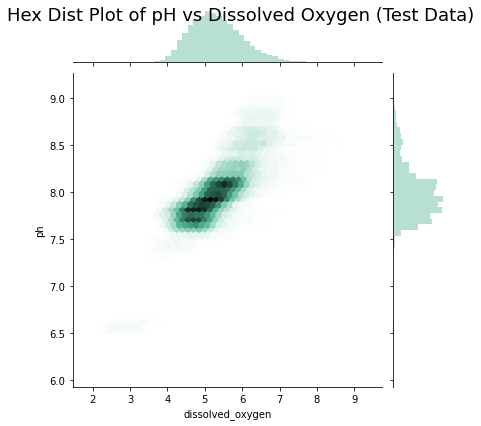

In [16]:
g =sns.jointplot('dissolved_oxygen','ph',  kind="hex", color="#4CB391", data=polat )
g.fig.suptitle('Hex Dist Plot of pH vs Dissolved Oxygen (Test Data)', fontsize=18)